# Lab3 参数估计&非参数估计

- 姓名：于洋淼
- 学号：2113644
- 专业：物联网工程

In [21]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 基本要求

In [22]:
# 生成正态分布数据
def getSample(mean, cov, P, label, num):
    '''
        mean 为均值向量
        cov 为方差矩阵
        P 为单个类的先验概率
        return 单个类的数据集
    '''
    temp_num = round(num*P)
    
    # 生成一个多元正态分布数据集
    data = np.random.multivariate_normal(mean, cov, temp_num)
    
    # 创建类别标签列
    labels = np.full((temp_num, 1), label)
    
    # 将类别标签添加到数据集中
    dataset = np.hstack((data, labels))
    
    return dataset

def getDataSet(mean, cov, P, num):
  # 按照先验概率生成正态分布数据
  # 返回所有类的数据集
    X = []
    X1 = []
    for i in range(3):
        # 把此时类i对应的数据集加到已有的数据集中
        X.extend(getSample(mean[i], cov, P[i], i+1, num))
        X1.append(getSample(mean[i], cov, P[i], i+1, num))
        i += 1

    return X, X1


作业要求的样本个数是1000，但是对于X1，三个分布的先验概率都是1/3，如果是sample_num设置为1000会导致最后得到的样本只有999个，后续处理不太方便。因此我设置为了1002

In [23]:
mean = np.array([[1, 4], [4, 1], [8, 4]])  # 均值数组
cov = [[2, 0], [0, 2]]  # 方差矩阵
num = 1002  # 样本个数
P1 = [1 / 3, 1 / 3, 1 / 3]  # X1的先验概率
P2 = [0.6, 0.1, 0.3]  # X2的先验概率

In [24]:
X1, X1_plt = getDataSet(mean, cov, P1, num)
X2, X2_plt = getDataSet(mean, cov, P2, num)

d:\Pro_CV\myvenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


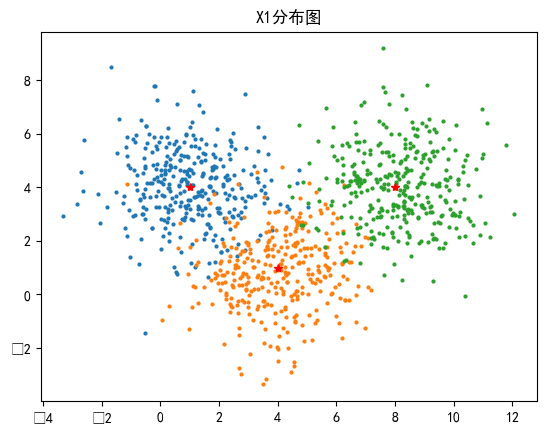

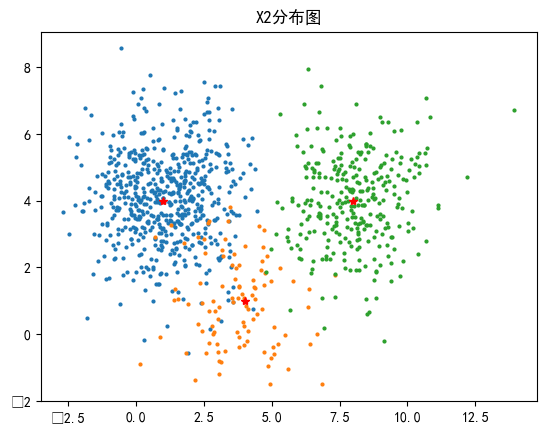

In [25]:
plt.title("X1分布图")
plt.rcParams['font.sans-serif'] = ['SimHei']
for i in range(3):
    #画出每类的样本向量(x,y)
    plt.plot(X1_plt[i][:, 0], X1_plt[i][:, 1], '.', markersize=4.)
    #画出每类的中心点(均值向量对应的点)
    plt.plot(mean[i][0], mean[i][1], 'r*')
plt.show()

plt.title("X2分布图")
plt.rcParams['font.sans-serif'] = ['SimHei']
for i in range(3):
    #画出每类的样本向量(x,y)
    plt.plot(X2_plt[i][:, 0], X2_plt[i][:, 1], '.', markersize=4.)
    #画出每类的中心点(均值向量对应的点)
    plt.plot(mean[i][0], mean[i][1], 'r*')
plt.show()

### 高斯

In [26]:
def Gaussian_function(x, mean, cov):
    """
    计算多元正态分布的概率密度函数值
    :param x: 输入数据点
    :param mean: 均值向量
    :param cov: 协方差矩阵
    :return: 概率密度函数值
    """
    # 计算协方差矩阵的行列式
    det_cov = np.linalg.det(cov)
    
    # 计算协方差矩阵的逆
    inv_cov = np.linalg.inv(cov)
    
    # 计算指数部分的值
    exponent = -0.5 * np.dot(np.dot((x - mean), inv_cov), (x - mean))
    
    # 计算概率密度函数值
    p = 1 / (np.sqrt((2 * np.pi) ** len(mean) * det_cov)) * np.exp(exponent)
    
    return p


### 似然率


In [27]:
#似然率测试函数
def Likelihood(X, mean, cov, p):
    class_num = mean.shape[0] #类的个数
    num = np.array(X).shape[0]
    error_rate = 0
    
    for i in range(num):
        temp = np.zeros(3)
        for j in range(class_num):
            temp[j] = Gaussian_function(X[i][0:2], mean[j], cov)  # 计算样本i决策到j类的概率
        p_class = np.argmax(temp) + 1                             # 得到样本i决策到的类
        
        if p_class != X[i][2]:                                    # 决策结果和真实结果不同
            error_rate += 1
    
    return error_rate/num

### 最大后验概率

In [28]:
##最大后验概率规则
def Max_Posterior(X, mean, cov, p):

    class_num = mean.shape[0] #类的个数
    num = np.array(X).shape[0]
    error_rate = 0
    
    for i in range(num):
        temp = np.zeros(3)
        for j in range(class_num):
            temp[j] = Gaussian_function(X[i][0:2], mean[j], cov) * p[j] # 计算样本i决策到j类的概率
        
        p_class = np.argmax(temp) + 1 # 得到样本i决策到的类
        
        if p_class != X[i][2]:        #决策结果和真实结果不同
            error_rate += 1
    
    return error_rate/num

In [29]:
# 单次试验求不同准则下的分类误差
def error_text(mean, cov, P1, P2, X1, X2):
    # 通过不同规则得到不同分类错误率并返回
    
    error = np.zeros((2, 2))
    # 计算似然率测试规则误差
    error_likelihood = Likelihood(X1, mean, cov, P1)
    error_likelihood_2 = Likelihood(X2, mean, cov, P2)
    error[0] = [error_likelihood, error_likelihood_2]
    # 计算最大后验概率规则误差
    error_Max_Posterior_Rule = Max_Posterior(X1, mean, cov, P1)
    error_Max_Posterior_Rule_2 = Max_Posterior(X2, mean, cov, P2)
    error[1] = [error_Max_Posterior_Rule, error_Max_Posterior_Rule_2]
    return error

In [30]:

error = error_text(mean,cov,P1,P2, X1, X2)
print(f'X1\t极似然规则误差{error[0][0]}\t最大后验规则误差{error[1][0]}\nX2\t极似然规则误差{error[0][1]}\t最大后验规则误差{error[1][1]}')


X1	极似然规则误差0.07684630738522955	最大后验规则误差0.07684630738522955
X2	极似然规则误差0.06786427145708583	最大后验规则误差0.04491017964071856


- 当每个类的先验概率P相同或差别不大时，极大似然率测试规则和最大后验概率规则分类结果相差不大
- 当先验概率相差较大时，最大后验概率规则更好一些

## 中级要求

在两个数据集合上使⽤⾼斯核函数估计⽅法，应⽤“似然率测试规则”分类和“最大后验概率规则”在 [0.1, 0.5, 1, 
1.5, 2] 范围内交叉验证找到最优 h 值，分析实验结果

### 交叉验证

In [31]:
#五折交叉验证
def FiveFold(X):
    #将原数组打乱
    datax = [[], [], [], [], []]
    x = [[], [], []]
    for i in range(num):
        if X[i][2]==1:
            x[0].append(X2[i])
        elif X[i][2]==2:
            x[1].append(X2[i])
        elif X[i][2]==3:
            x[2].append(X2[i])

    for k in range(3):
        np.random.shuffle(x[k])
        length = len(x[k])
        n = 5
        for i in range(n):
            x_tmp = x[k][math.floor(i / n * length): math.floor((i + 1) / n * length)]
            if k == 0:
                datax[i] = x_tmp
            else:
                datax[i] = np.vstack((datax[i], x_tmp))

    return datax

In [32]:
datax1 = FiveFold(X1)
datax2 = FiveFold(X2)

### 高斯核函数

In [33]:
def Gaussian_kernel(x, X, h = 2):
    kernel_values = []
    
    # 遍历样本点集合 X
    for i in range(len(X)):
        # 计算高斯核函数的值
        kernel_value = (1 / (np.sqrt(2 * np.pi) * h)) * np.exp(-0.5 * np.dot(x - X[i], x - X[i]) / (h**2))
        kernel_values.append(kernel_value)
    
    # 计算概率密度
    p = np.mean(kernel_values)
    
    return p

### 似然率测试规则

In [34]:
def Likelihood_kernel(X, x, h):
    class_num = 3  # 类的个数
    num = np.array(x).shape[0]
    num1 = np.array(X).shape[0]
    error_rate = 0
    x1 = []
    x2 = []
    x3 = []
    xs = [[], [], []]
    for i in range(num1):
        if X[i][2] == 1:
            xs[0].append(X[i][0:2])
        elif X[i][2] == 2:
            xs[1].append(X[i][0:2])
        elif X[i][2] == 3:
            xs[2].append(X[i][0:2])
    for i in range(num):
        p_temp = np.zeros(3)
        for j in range(class_num):
            p_temp[j] = Gaussian_kernel(x[i][0:2], xs[j], h)
        p_class = np.argmax(p_temp) + 1  
        if p_class != x[i][2]:
            error_rate += 1
    return error_rate / num

### 最大后验概率规则

In [35]:
def Max_kernel(X, x, h, p):
    class_num = 3  # 类的个数
    num = np.array(x).shape[0]
    num1 = np.array(X).shape[0]
    error_rate = 0
    x1 = []
    x2 = []
    x3 = []
    xs = [[], [], []]
    for i in range(num1):
        if X[i][2] == 1:
            xs[0].append(X[i][0:2])
        elif X[i][2] == 2:
            xs[1].append(X[i][0:2])
        elif X[i][2] == 3:
            xs[2].append(X[i][0:2])
    for i in range(num):
        p_temp = np.zeros(3)
        for j in range(class_num):
            p_temp[j] = Gaussian_kernel(x[i][0:2], xs[j], h)*p[j]
        p_class = np.argmax(p_temp) + 1  
        if p_class != x[i][2]:
            error_rate += 1
    return error_rate / num

In [36]:
def cross_test(datax, h, p):
    data_tmp = []
    tmp = [0, 0, 0, 0, 0]
    tmp1 = [0, 0, 0, 0, 0]
    for i in range(5):
        if i == 0:
            data_tmp = np.vstack((datax[1], datax[2], datax[3], datax[4]))
        if i == 1:
            data_tmp = np.vstack((datax[0], datax[2], datax[3], datax[4]))
        if i == 2:
            data_tmp = np.vstack((datax[0], datax[1], datax[3], datax[4]))
        if i == 3:
            data_tmp = np.vstack((datax[0], datax[1], datax[2], datax[4]))
        if i == 4:
            data_tmp = np.vstack((datax[1], datax[2], datax[3], datax[0]))
        # data_tmp[]
        datai = np.array(datax[i])
        tmp[i] = Likelihood_kernel(data_tmp, datai, h)
        tmp1[i] = Max_kernel(data_tmp, datai, h, p)
    error = 0
    error1 = 0
    for i in range(5):
        error += tmp[i]
        error1 += tmp1[i]
    return error / 5, error1 / 5

In [37]:
tmp = [0.1, 0.5, 1, 1.5, 2]
print('对于X1')
for i in tmp:
    res, res1 = cross_test(datax1, i, P1)
    res = np.around(res, 5)
    res1 = np.around(res1, 5)
    print("h = {}时, 似然率规则错误率 = {}, 最大后验概率规则错误率 = {}".format(i, res, res1))
print('对于X2')
for i in tmp:
    res, res1 = cross_test(datax2, i, P2)
    res = np.around(res, 5)
    res1 = np.around(res1, 5)
    print("h = {}时, 似然率规则错误率 = {}, 最大后验概率规则错误率 = {}".format(i, res, res1))

对于X1
h = 0.1时, 似然率规则错误率 = 0.07182, 最大后验概率规则错误率 = 0.07182
h = 0.5时, 似然率规则错误率 = 0.07297, 最大后验概率规则错误率 = 0.07297
h = 1时, 似然率规则错误率 = 0.07197, 最大后验概率规则错误率 = 0.07197
h = 1.5时, 似然率规则错误率 = 0.07496, 最大后验概率规则错误率 = 0.07496
h = 2时, 似然率规则错误率 = 0.07295, 最大后验概率规则错误率 = 0.07295
对于X2
h = 0.1时, 似然率规则错误率 = 0.07785, 最大后验概率规则错误率 = 0.06784
h = 0.5时, 似然率规则错误率 = 0.07288, 最大后验概率规则错误率 = 0.0499
h = 1时, 似然率规则错误率 = 0.06988, 最大后验概率规则错误率 = 0.0509
h = 1.5时, 似然率规则错误率 = 0.07287, 最大后验概率规则错误率 = 0.06687
h = 2时, 似然率规则错误率 = 0.07187, 最大后验概率规则错误率 = 0.08683


根据误差的均值可知，最优的h值为0.5

## 高级要求

In [38]:
data1 = pd.DataFrame(X1)
data2 = pd.DataFrame(X2)
# 分割训练集和测试集
train_data1, text_data1 = train_test_split(data1, test_size=0.2, random_state=0)
train_data2, text_data2 = train_test_split(data2, test_size=0.2, random_state=0)

In [39]:
# 找最邻近k点并计算p
def k_find(x,X,k):
    num=np.array(X).shape[0]
    dis=[]
    for i in range(num):
        dis.append(np.linalg.norm(x-X[i][0:2],ord=2))
    dis=np.array(dis)
    index=dis.argsort()
    d=np.zeros(k)
    point=[]
    for i in range(k):
        d[i]=dis[index[i]]
        point.append(X[index[i]])
    class_num=np.zeros(3)
    for i in range(k):
        if point[i][2] == 1:
            class_num[0]+=1
        if point[i][2] == 2:
            class_num[1]+=1
        if point[i][2] == 3:
            class_num[2]+=1
    V=np.pi*d[k-1]*d[k-1]
    p=class_num/(2*V)
    p_class = np.argmax(p) + 1
    return p_class

# k最近验证
def k_trials(mean, cov, P1, P2,k, X1, X2, X1_test, X2_test):

    error_rate_1=0
    error_rate_2=0

    num=np.array(X1_test).shape[0]
    for i in range(num):
        if X1_test[i][2] != k_find(X1_test[i][0:2],X1,k):
            error_rate_1 += 1
    error_rate_1=error_rate_1/num

    for i in range(num):
        if X2_test[i][2] != k_find(X2_test[i][0:2],X2,k):
            error_rate_2 += 1
    error_rate_2=error_rate_2/num
    
    print(f'k={k}, X1错误率={error_rate_1}, X2错误率={error_rate_2}')

In [40]:
K=[1,3,5]
for k in K:
    k_trials(mean,cov,P1,P2,k, np.array(train_data1), np.array(train_data2), np.array(text_data1), np.array(text_data2))

k=1, X1错误率=0.07462686567164178, X2错误率=0.05472636815920398
k=3, X1错误率=0.05970149253731343, X2错误率=0.04975124378109453
k=5, X1错误率=0.03980099502487562, X2错误率=0.04477611940298507
